# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter





class Seed_Layer(nn.Module):
    def __init__(self, in_channels):
        super(Seed_Layer,self).__init__()
        
        self.weight= Parameter(torch.Tensor(1,in_channels))
        self.a=torch.rand(1,in_channels,dtype=torch.float32)*2-1
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.uniform_(self.weight.data,-1,1) # More Method
    
    def forward(self):
#         a=torch.randn(1)*0.1
#         print_prob=0.36  # 控制显示tensor信息的概率
#         if a>print_prob:
#             print(self.weight)
            
        #return self.weight
        
        self.weight=Parameter(self.a)
        
        return self.weight


class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=False)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.seed_layer=Seed_Layer(in_planes)
        #rint(self.seed_layer.weight.dtype)
        
        

    def forward(self, x):
        
        # 【bs,c_in,h,w】
        out = F.relu6(self.bn1(self.conv1(x)))
        # 【bs,c_in,h,w】,if stride==1,else 【bs,c_in,h/2,w/2】
        
        # -------------------------- Attention -----------------------
        w=self.seed_layer()
        
#         a=torch.randn(1)*0.1
#         print_prob=0.35  # 控制显示tensor信息的概率
#         if a>print_prob:
#             print(w)
        
        in_channel=w.shape[1]
     
        w=w.view(1,1,in_channel) # 改变格式
        
        w=self.scaleLayer(w.cuda())  #自动缩放层 可以激活或者不激活 甚至采用多级缩放    
        
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        
        
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #--------------------通过非线性激活函数-----------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
            
        # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out




class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 10*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [ ]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
#from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()


#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.308948, Accuracy: 13.28
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.108240, Accuracy: 22.27
Train Epoch: 0 [5120/50000 (11%)]	Loss: 1.932578, Accuracy: 25.00
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.925390, Accuracy: 27.34
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.843375, Accuracy: 25.39
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.830940, Accuracy: 29.69
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.757636, Accuracy: 31.25
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.651710, Accuracy: 38.28
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.667558, Accuracy: 35.16
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.568424, Accuracy: 37.89
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.624465, Accuracy: 42.19
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.595186, Accuracy: 42.19
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.505885, Accuracy: 46.48
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.587764, Accuracy: 41.80
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.527323, Accuracy: 47.27
Trai

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.583333, Accuracy: 81.25
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.549051, Accuracy: 80.08
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.600383, Accuracy: 78.12
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.604019, Accuracy: 77.34
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.567943, Accuracy: 81.25
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.689406, Accuracy: 76.95
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.634414, Accuracy: 78.52
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.522309, Accuracy: 81.25
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.651680, Accuracy: 79.69
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.634781, Accuracy: 77.34
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.562424, Accuracy: 82.03
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.503372, Accuracy: 81.64
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.595817, Accuracy: 78.52

Validation set: Average loss: 0.7109, Accuracy: 3826/5000 (76.00%)

the time of this epoch:[35.69557309150696 s]
Train Epoch: 7 

Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.395359, Accuracy: 86.33
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.455808, Accuracy: 83.98
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.518138, Accuracy: 82.03
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.494458, Accuracy: 82.42
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.488206, Accuracy: 82.81
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.493259, Accuracy: 84.77
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.538605, Accuracy: 80.08
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.424204, Accuracy: 85.16
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.435135, Accuracy: 82.81

Validation set: Average loss: 0.8360, Accuracy: 3610/5000 (72.00%)

the time of this epoch:[36.321616649627686 s]

Test set: Average loss: 0.8289, Accuracy: 7219/10000 (72.19%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.369072, Accuracy: 89.06
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.459149, Accuracy: 83.98
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.445454, Accuracy: 84.38
Train Epoch: 

Train Epoch: 18 [25600/50000 (57%)]	Loss: 0.430418, Accuracy: 85.55
Train Epoch: 18 [28160/50000 (62%)]	Loss: 0.503225, Accuracy: 81.25
Train Epoch: 18 [30720/50000 (68%)]	Loss: 0.531243, Accuracy: 82.03
Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.439482, Accuracy: 84.77
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.422028, Accuracy: 85.94
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.478441, Accuracy: 83.20
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.455078, Accuracy: 86.33
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.461190, Accuracy: 85.16

Validation set: Average loss: 0.6073, Accuracy: 4006/5000 (80.00%)

the time of this epoch:[36.27199983596802 s]

Test set: Average loss: 0.6586, Accuracy: 7864/10000 (78.64%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.352442, Accuracy: 86.33
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.458644, Accuracy: 85.55
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.443170, Accuracy: 84.77
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.405247, Accuracy: 87.11
Train Epoch: 19

Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.425396, Accuracy: 84.77
Train Epoch: 24 [30720/50000 (68%)]	Loss: 0.448164, Accuracy: 83.59
Train Epoch: 24 [33280/50000 (74%)]	Loss: 0.396847, Accuracy: 86.72
Train Epoch: 24 [35840/50000 (80%)]	Loss: 0.346449, Accuracy: 87.50
Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.386070, Accuracy: 87.89
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.450248, Accuracy: 82.81
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.411986, Accuracy: 85.55

Validation set: Average loss: 0.5288, Accuracy: 4125/5000 (82.00%)

the time of this epoch:[37.14894986152649 s]

Test set: Average loss: 0.5518, Accuracy: 8183/10000 (81.83%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.383664, Accuracy: 86.72
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.469764, Accuracy: 83.59
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.349955, Accuracy: 88.28
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.408925, Accuracy: 87.50
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.333053, Accuracy: 87.11
Train Epoch: 25

Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.363139, Accuracy: 89.45
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.457681, Accuracy: 82.42
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.288197, Accuracy: 89.45
Train Epoch: 30 [38400/50000 (85%)]	Loss: 0.333667, Accuracy: 88.67
Train Epoch: 30 [40960/50000 (91%)]	Loss: 0.347486, Accuracy: 87.89
Train Epoch: 30 [43520/50000 (97%)]	Loss: 0.353889, Accuracy: 87.50

Validation set: Average loss: 0.5724, Accuracy: 4050/5000 (81.00%)

the time of this epoch:[37.00617456436157 s]

Test set: Average loss: 0.6065, Accuracy: 8066/10000 (80.66%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.298386, Accuracy: 90.23
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.389595, Accuracy: 87.50
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.317650, Accuracy: 91.41
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.321423, Accuracy: 87.89
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.381707, Accuracy: 88.28
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.561785, Accuracy: 80.47
Train Epoch: 31

Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.384775, Accuracy: 87.11
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.482020, Accuracy: 84.77
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.496406, Accuracy: 82.81
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.412697, Accuracy: 85.55
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.390455, Accuracy: 86.33

Validation set: Average loss: 0.5331, Accuracy: 4099/5000 (81.00%)

the time of this epoch:[35.38638520240784 s]

Test set: Average loss: 0.5628, Accuracy: 8121/10000 (81.21%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.400762, Accuracy: 86.72
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.345169, Accuracy: 87.50
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.314510, Accuracy: 89.84
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.355307, Accuracy: 88.28
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.351372, Accuracy: 89.84
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.321500, Accuracy: 89.45
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.347673, Accuracy: 89.45
Train Epoch: 37

Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.374176, Accuracy: 88.67
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.461332, Accuracy: 85.94
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.375068, Accuracy: 89.06
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.337416, Accuracy: 89.45

Validation set: Average loss: 0.5614, Accuracy: 4081/5000 (81.00%)

the time of this epoch:[35.5777792930603 s]

Test set: Average loss: 0.5767, Accuracy: 8053/10000 (80.53%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.334333, Accuracy: 85.94
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.287663, Accuracy: 90.23
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.302452, Accuracy: 88.28
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.338775, Accuracy: 88.28
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.460403, Accuracy: 83.98
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.441288, Accuracy: 87.89
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.365442, Accuracy: 88.67
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.376943, Accuracy: 87.50
Train Epoch: 43 

Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.452544, Accuracy: 85.55
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.374849, Accuracy: 88.67
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.389980, Accuracy: 86.72

Validation set: Average loss: 0.5209, Accuracy: 4135/5000 (82.00%)

the time of this epoch:[36.83594274520874 s]

Test set: Average loss: 0.5631, Accuracy: 8134/10000 (81.34%)

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.368053, Accuracy: 88.28
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.311399, Accuracy: 88.67
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.273653, Accuracy: 91.02
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.325332, Accuracy: 88.28
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.302488, Accuracy: 89.06
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.309476, Accuracy: 90.23
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.329172, Accuracy: 87.50
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.320427, Accuracy: 89.06
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.354057, Accuracy: 89.84
Train Epoch: 49

Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.430351, Accuracy: 84.77
Train Epoch: 54 [43520/50000 (97%)]	Loss: 0.348451, Accuracy: 87.50

Validation set: Average loss: 0.6463, Accuracy: 3951/5000 (79.00%)

the time of this epoch:[35.59473276138306 s]

Test set: Average loss: 0.6400, Accuracy: 7877/10000 (78.77%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.331337, Accuracy: 88.28
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.433503, Accuracy: 85.16
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.339170, Accuracy: 88.28
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.370394, Accuracy: 89.06
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.388330, Accuracy: 85.55
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.308094, Accuracy: 88.67
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.334656, Accuracy: 88.67
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.421772, Accuracy: 85.94
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.393407, Accuracy: 88.67
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.306535, Accuracy: 89.84
Train Epoch: 55

Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.288389, Accuracy: 89.45

Validation set: Average loss: 0.5371, Accuracy: 4097/5000 (81.00%)

the time of this epoch:[37.337855100631714 s]

Test set: Average loss: 0.5598, Accuracy: 8156/10000 (81.56%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.350271, Accuracy: 87.50
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.463728, Accuracy: 82.81
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.318106, Accuracy: 89.45
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.353131, Accuracy: 86.72
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.392236, Accuracy: 87.89
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.410021, Accuracy: 85.16
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.246154, Accuracy: 93.36
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.425984, Accuracy: 86.33
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.336795, Accuracy: 87.11
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.476743, Accuracy: 85.55
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.401177, Accuracy: 86.33
Train Epoch: 6


Validation set: Average loss: 0.9542, Accuracy: 3671/5000 (73.00%)

the time of this epoch:[36.323375940322876 s]

Test set: Average loss: 0.9859, Accuracy: 7293/10000 (72.93%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.302254, Accuracy: 90.62
Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.395565, Accuracy: 85.16
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.430352, Accuracy: 84.77
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.335145, Accuracy: 90.62
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.289088, Accuracy: 89.84
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.340779, Accuracy: 87.50
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.381789, Accuracy: 86.33
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.319439, Accuracy: 89.84
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.260911, Accuracy: 92.97
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.320040, Accuracy: 89.06
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.448077, Accuracy: 85.55
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.401494, Accuracy: 86.72
Train Epoch: 6


Test set: Average loss: 0.5569, Accuracy: 8244/10000 (82.44%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.437051, Accuracy: 85.16
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.352253, Accuracy: 87.11
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.350979, Accuracy: 88.67
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.392181, Accuracy: 87.89
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.432792, Accuracy: 84.38
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.349443, Accuracy: 87.50
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.434027, Accuracy: 88.67
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.278037, Accuracy: 88.67
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.327745, Accuracy: 87.89
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.337136, Accuracy: 89.45
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.305819, Accuracy: 89.45
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.320920, Accuracy: 88.28
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.399877, Accuracy: 85.16
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.368020, Accuracy:

Train Epoch: 79 [2560/50000 (6%)]	Loss: 0.413123, Accuracy: 87.11
Train Epoch: 79 [5120/50000 (11%)]	Loss: 0.276388, Accuracy: 90.62
Train Epoch: 79 [7680/50000 (17%)]	Loss: 0.358201, Accuracy: 86.33
Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.330702, Accuracy: 86.33
Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.315096, Accuracy: 87.50
Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.308017, Accuracy: 87.11
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.399518, Accuracy: 86.33
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.339404, Accuracy: 88.28
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.363606, Accuracy: 87.50
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.332141, Accuracy: 89.45
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.349999, Accuracy: 88.67
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.418809, Accuracy: 86.33
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.339440, Accuracy: 89.06
Train Epoch: 79 [35840/50000 (80%)]	Loss: 0.424269, Accuracy: 85.94
Train Epoch: 79 [38400/50000 (85%)]	Loss: 0.354054, 

Train Epoch: 85 [5120/50000 (11%)]	Loss: 0.349743, Accuracy: 88.67
Train Epoch: 85 [7680/50000 (17%)]	Loss: 0.334392, Accuracy: 88.28
Train Epoch: 85 [10240/50000 (23%)]	Loss: 0.251707, Accuracy: 90.62
Train Epoch: 85 [12800/50000 (28%)]	Loss: 0.351046, Accuracy: 87.11
Train Epoch: 85 [15360/50000 (34%)]	Loss: 0.383678, Accuracy: 87.11
Train Epoch: 85 [17920/50000 (40%)]	Loss: 0.352513, Accuracy: 86.72
Train Epoch: 85 [20480/50000 (45%)]	Loss: 0.398373, Accuracy: 87.11
Train Epoch: 85 [23040/50000 (51%)]	Loss: 0.309603, Accuracy: 90.62
Train Epoch: 85 [25600/50000 (57%)]	Loss: 0.347698, Accuracy: 87.89
Train Epoch: 85 [28160/50000 (62%)]	Loss: 0.349415, Accuracy: 87.50
Train Epoch: 85 [30720/50000 (68%)]	Loss: 0.379486, Accuracy: 85.16
Train Epoch: 85 [33280/50000 (74%)]	Loss: 0.390216, Accuracy: 87.50
Train Epoch: 85 [35840/50000 (80%)]	Loss: 0.438013, Accuracy: 85.16
Train Epoch: 85 [38400/50000 (85%)]	Loss: 0.322516, Accuracy: 90.23
Train Epoch: 85 [40960/50000 (91%)]	Loss: 0.532917

Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.347341, Accuracy: 88.67
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.319959, Accuracy: 90.23
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.476257, Accuracy: 82.81
Train Epoch: 91 [15360/50000 (34%)]	Loss: 0.280916, Accuracy: 91.80
Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.299512, Accuracy: 91.02
Train Epoch: 91 [20480/50000 (45%)]	Loss: 0.306384, Accuracy: 87.50
Train Epoch: 91 [23040/50000 (51%)]	Loss: 0.372712, Accuracy: 87.50
Train Epoch: 91 [25600/50000 (57%)]	Loss: 0.430765, Accuracy: 85.94
Train Epoch: 91 [28160/50000 (62%)]	Loss: 0.356504, Accuracy: 87.89
Train Epoch: 91 [30720/50000 (68%)]	Loss: 0.340727, Accuracy: 90.62
Train Epoch: 91 [33280/50000 (74%)]	Loss: 0.340530, Accuracy: 90.23
Train Epoch: 91 [35840/50000 (80%)]	Loss: 0.363013, Accuracy: 87.50
Train Epoch: 91 [38400/50000 (85%)]	Loss: 0.297562, Accuracy: 89.45
Train Epoch: 91 [40960/50000 (91%)]	Loss: 0.347945, Accuracy: 87.89
Train Epoch: 91 [43520/50000 (97%)]	Loss: 0.37839

Train Epoch: 97 [10240/50000 (23%)]	Loss: 0.289076, Accuracy: 91.80
Train Epoch: 97 [12800/50000 (28%)]	Loss: 0.376139, Accuracy: 85.55
Train Epoch: 97 [15360/50000 (34%)]	Loss: 0.432485, Accuracy: 84.77
Train Epoch: 97 [17920/50000 (40%)]	Loss: 0.370502, Accuracy: 87.11
Train Epoch: 97 [20480/50000 (45%)]	Loss: 0.466419, Accuracy: 85.16
Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.317705, Accuracy: 88.28
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.389141, Accuracy: 87.11
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.373515, Accuracy: 87.11
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.327034, Accuracy: 89.06
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.474208, Accuracy: 86.33
Train Epoch: 97 [35840/50000 (80%)]	Loss: 0.321754, Accuracy: 90.62
Train Epoch: 97 [38400/50000 (85%)]	Loss: 0.293016, Accuracy: 90.23
Train Epoch: 97 [40960/50000 (91%)]	Loss: 0.387371, Accuracy: 85.94
Train Epoch: 97 [43520/50000 (97%)]	Loss: 0.419946, Accuracy: 83.98

Validation set: Average loss: 0.5173, Accuracy:

Train Epoch: 103 [10240/50000 (23%)]	Loss: 0.414666, Accuracy: 85.55
Train Epoch: 103 [12800/50000 (28%)]	Loss: 0.388818, Accuracy: 86.72
Train Epoch: 103 [15360/50000 (34%)]	Loss: 0.321218, Accuracy: 88.28
Train Epoch: 103 [17920/50000 (40%)]	Loss: 0.345465, Accuracy: 89.45
Train Epoch: 103 [20480/50000 (45%)]	Loss: 0.346969, Accuracy: 88.67
Train Epoch: 103 [23040/50000 (51%)]	Loss: 0.424378, Accuracy: 86.72
Train Epoch: 103 [25600/50000 (57%)]	Loss: 0.310781, Accuracy: 89.84
Train Epoch: 103 [28160/50000 (62%)]	Loss: 0.388881, Accuracy: 86.72
Train Epoch: 103 [30720/50000 (68%)]	Loss: 0.537170, Accuracy: 80.47
Train Epoch: 103 [33280/50000 (74%)]	Loss: 0.429468, Accuracy: 85.55
Train Epoch: 103 [35840/50000 (80%)]	Loss: 0.289688, Accuracy: 91.80
Train Epoch: 103 [38400/50000 (85%)]	Loss: 0.384658, Accuracy: 87.50
Train Epoch: 103 [40960/50000 (91%)]	Loss: 0.392598, Accuracy: 85.16
Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.331351, Accuracy: 86.72

Validation set: Average loss: 0.6

Train Epoch: 109 [7680/50000 (17%)]	Loss: 0.382461, Accuracy: 87.50
Train Epoch: 109 [10240/50000 (23%)]	Loss: 0.266690, Accuracy: 92.19
Train Epoch: 109 [12800/50000 (28%)]	Loss: 0.368751, Accuracy: 86.72
Train Epoch: 109 [15360/50000 (34%)]	Loss: 0.312573, Accuracy: 90.62
Train Epoch: 109 [17920/50000 (40%)]	Loss: 0.408129, Accuracy: 86.33
Train Epoch: 109 [20480/50000 (45%)]	Loss: 0.339161, Accuracy: 89.84
Train Epoch: 109 [23040/50000 (51%)]	Loss: 0.386945, Accuracy: 87.11
Train Epoch: 109 [25600/50000 (57%)]	Loss: 0.361119, Accuracy: 87.50
Train Epoch: 109 [28160/50000 (62%)]	Loss: 0.481428, Accuracy: 81.64
Train Epoch: 109 [30720/50000 (68%)]	Loss: 0.395721, Accuracy: 84.38
Train Epoch: 109 [33280/50000 (74%)]	Loss: 0.391596, Accuracy: 86.33
Train Epoch: 109 [35840/50000 (80%)]	Loss: 0.343562, Accuracy: 87.50
Train Epoch: 109 [38400/50000 (85%)]	Loss: 0.283661, Accuracy: 88.67
Train Epoch: 109 [40960/50000 (91%)]	Loss: 0.303952, Accuracy: 89.45
Train Epoch: 109 [43520/50000 (97%)

Train Epoch: 115 [5120/50000 (11%)]	Loss: 0.391546, Accuracy: 86.33
Train Epoch: 115 [7680/50000 (17%)]	Loss: 0.311965, Accuracy: 89.45
Train Epoch: 115 [10240/50000 (23%)]	Loss: 0.396347, Accuracy: 87.11
Train Epoch: 115 [12800/50000 (28%)]	Loss: 0.282929, Accuracy: 90.23
Train Epoch: 115 [15360/50000 (34%)]	Loss: 0.247035, Accuracy: 91.02
Train Epoch: 115 [17920/50000 (40%)]	Loss: 0.322262, Accuracy: 89.06
Train Epoch: 115 [20480/50000 (45%)]	Loss: 0.301436, Accuracy: 87.89
Train Epoch: 115 [23040/50000 (51%)]	Loss: 0.337975, Accuracy: 88.67
Train Epoch: 115 [25600/50000 (57%)]	Loss: 0.361403, Accuracy: 88.67
Train Epoch: 115 [28160/50000 (62%)]	Loss: 0.387169, Accuracy: 87.11
Train Epoch: 115 [30720/50000 (68%)]	Loss: 0.379591, Accuracy: 86.72
Train Epoch: 115 [33280/50000 (74%)]	Loss: 0.431439, Accuracy: 83.59
Train Epoch: 115 [35840/50000 (80%)]	Loss: 0.382534, Accuracy: 87.89
Train Epoch: 115 [38400/50000 (85%)]	Loss: 0.244522, Accuracy: 91.02
Train Epoch: 115 [40960/50000 (91%)]

Train Epoch: 121 [2560/50000 (6%)]	Loss: 0.342729, Accuracy: 87.11
Train Epoch: 121 [5120/50000 (11%)]	Loss: 0.282133, Accuracy: 89.06
Train Epoch: 121 [7680/50000 (17%)]	Loss: 0.370185, Accuracy: 87.50
Train Epoch: 121 [10240/50000 (23%)]	Loss: 0.382671, Accuracy: 86.33
Train Epoch: 121 [12800/50000 (28%)]	Loss: 0.378234, Accuracy: 87.11
Train Epoch: 121 [15360/50000 (34%)]	Loss: 0.366216, Accuracy: 87.50
Train Epoch: 121 [17920/50000 (40%)]	Loss: 0.352862, Accuracy: 88.67
Train Epoch: 121 [20480/50000 (45%)]	Loss: 0.472030, Accuracy: 85.55
Train Epoch: 121 [23040/50000 (51%)]	Loss: 0.450542, Accuracy: 85.94
Train Epoch: 121 [25600/50000 (57%)]	Loss: 0.355806, Accuracy: 87.50
Train Epoch: 121 [28160/50000 (62%)]	Loss: 0.332029, Accuracy: 89.84
Train Epoch: 121 [30720/50000 (68%)]	Loss: 0.426242, Accuracy: 83.20
Train Epoch: 121 [33280/50000 (74%)]	Loss: 0.271990, Accuracy: 91.41
Train Epoch: 121 [35840/50000 (80%)]	Loss: 0.465940, Accuracy: 82.42
Train Epoch: 121 [38400/50000 (85%)]	L

Train Epoch: 127 [2560/50000 (6%)]	Loss: 0.408845, Accuracy: 85.16
Train Epoch: 127 [5120/50000 (11%)]	Loss: 0.243540, Accuracy: 91.80
Train Epoch: 127 [7680/50000 (17%)]	Loss: 0.266407, Accuracy: 90.23
Train Epoch: 127 [10240/50000 (23%)]	Loss: 0.462626, Accuracy: 84.38
Train Epoch: 127 [12800/50000 (28%)]	Loss: 0.347195, Accuracy: 88.67
Train Epoch: 127 [15360/50000 (34%)]	Loss: 0.346123, Accuracy: 86.72
Train Epoch: 127 [17920/50000 (40%)]	Loss: 0.369458, Accuracy: 87.89
Train Epoch: 127 [20480/50000 (45%)]	Loss: 0.446971, Accuracy: 84.77
Train Epoch: 127 [23040/50000 (51%)]	Loss: 0.370808, Accuracy: 87.11
Train Epoch: 127 [25600/50000 (57%)]	Loss: 0.274899, Accuracy: 89.45
Train Epoch: 127 [28160/50000 (62%)]	Loss: 0.397944, Accuracy: 87.50
Train Epoch: 127 [30720/50000 (68%)]	Loss: 0.422202, Accuracy: 87.11
Train Epoch: 127 [33280/50000 (74%)]	Loss: 0.375020, Accuracy: 87.11
Train Epoch: 127 [35840/50000 (80%)]	Loss: 0.336279, Accuracy: 89.06
Train Epoch: 127 [38400/50000 (85%)]	L

Train Epoch: 133 [0/50000 (0%)]	Loss: 0.381003, Accuracy: 89.45
Train Epoch: 133 [2560/50000 (6%)]	Loss: 0.299336, Accuracy: 89.06
Train Epoch: 133 [5120/50000 (11%)]	Loss: 0.339865, Accuracy: 87.11
Train Epoch: 133 [7680/50000 (17%)]	Loss: 0.297163, Accuracy: 90.23
Train Epoch: 133 [10240/50000 (23%)]	Loss: 0.336317, Accuracy: 87.50
Train Epoch: 133 [12800/50000 (28%)]	Loss: 0.350948, Accuracy: 87.50
Train Epoch: 133 [15360/50000 (34%)]	Loss: 0.370256, Accuracy: 85.55
Train Epoch: 133 [17920/50000 (40%)]	Loss: 0.383354, Accuracy: 85.94
Train Epoch: 133 [20480/50000 (45%)]	Loss: 0.399873, Accuracy: 87.50
Train Epoch: 133 [23040/50000 (51%)]	Loss: 0.310081, Accuracy: 89.84
Train Epoch: 133 [25600/50000 (57%)]	Loss: 0.447726, Accuracy: 84.38
Train Epoch: 133 [28160/50000 (62%)]	Loss: 0.366515, Accuracy: 86.72
Train Epoch: 133 [30720/50000 (68%)]	Loss: 0.330349, Accuracy: 88.28
Train Epoch: 133 [33280/50000 (74%)]	Loss: 0.323953, Accuracy: 88.28
Train Epoch: 133 [35840/50000 (80%)]	Loss: 


Test set: Average loss: 0.5640, Accuracy: 8070/10000 (80.70%)

Train Epoch: 139 [0/50000 (0%)]	Loss: 0.312495, Accuracy: 89.84
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.343103, Accuracy: 87.50
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.324607, Accuracy: 90.62
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.349131, Accuracy: 86.72
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.325777, Accuracy: 89.06
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.320673, Accuracy: 88.67
Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.351515, Accuracy: 87.89
Train Epoch: 139 [17920/50000 (40%)]	Loss: 0.460321, Accuracy: 85.55
Train Epoch: 139 [20480/50000 (45%)]	Loss: 0.315848, Accuracy: 88.67
Train Epoch: 139 [23040/50000 (51%)]	Loss: 0.369882, Accuracy: 86.72
Train Epoch: 139 [25600/50000 (57%)]	Loss: 0.383670, Accuracy: 84.77
Train Epoch: 139 [28160/50000 (62%)]	Loss: 0.327325, Accuracy: 87.89
Train Epoch: 139 [30720/50000 (68%)]	Loss: 0.384457, Accuracy: 86.33
Train Epoch: 139 [33280/50000 (74%)]	Loss: 0.342


Test set: Average loss: 0.5234, Accuracy: 8298/10000 (82.98%)

Train Epoch: 145 [0/50000 (0%)]	Loss: 0.377288, Accuracy: 88.67
Train Epoch: 145 [2560/50000 (6%)]	Loss: 0.420336, Accuracy: 87.11
Train Epoch: 145 [5120/50000 (11%)]	Loss: 0.367330, Accuracy: 87.50
Train Epoch: 145 [7680/50000 (17%)]	Loss: 0.353178, Accuracy: 86.33
Train Epoch: 145 [10240/50000 (23%)]	Loss: 0.326273, Accuracy: 87.50
Train Epoch: 145 [12800/50000 (28%)]	Loss: 0.304151, Accuracy: 87.50
Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.326492, Accuracy: 89.45
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.357211, Accuracy: 86.72
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.401136, Accuracy: 87.11
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.384062, Accuracy: 87.89
Train Epoch: 145 [25600/50000 (57%)]	Loss: 0.396333, Accuracy: 87.11
Train Epoch: 145 [28160/50000 (62%)]	Loss: 0.314544, Accuracy: 89.45
Train Epoch: 145 [30720/50000 (68%)]	Loss: 0.363954, Accuracy: 87.11
Train Epoch: 145 [33280/50000 (74%)]	Loss: 0.471


Test set: Average loss: 0.8298, Accuracy: 7389/10000 (73.89%)

Train Epoch: 151 [0/50000 (0%)]	Loss: 0.430142, Accuracy: 87.89
Train Epoch: 151 [2560/50000 (6%)]	Loss: 0.311493, Accuracy: 89.84
Train Epoch: 151 [5120/50000 (11%)]	Loss: 0.374555, Accuracy: 87.50
Train Epoch: 151 [7680/50000 (17%)]	Loss: 0.204799, Accuracy: 94.14
Train Epoch: 151 [10240/50000 (23%)]	Loss: 0.156279, Accuracy: 95.31
Train Epoch: 151 [12800/50000 (28%)]	Loss: 0.218458, Accuracy: 92.19
Train Epoch: 151 [15360/50000 (34%)]	Loss: 0.297414, Accuracy: 90.23
Train Epoch: 151 [17920/50000 (40%)]	Loss: 0.202991, Accuracy: 94.53
Train Epoch: 151 [20480/50000 (45%)]	Loss: 0.165074, Accuracy: 94.92
Train Epoch: 151 [23040/50000 (51%)]	Loss: 0.206308, Accuracy: 92.97
Train Epoch: 151 [25600/50000 (57%)]	Loss: 0.264293, Accuracy: 92.97
Train Epoch: 151 [28160/50000 (62%)]	Loss: 0.214265, Accuracy: 92.58
Train Epoch: 151 [30720/50000 (68%)]	Loss: 0.212315, Accuracy: 92.58
Train Epoch: 151 [33280/50000 (74%)]	Loss: 0.219


Test set: Average loss: 0.2793, Accuracy: 9143/10000 (91.43%)

Train Epoch: 157 [0/50000 (0%)]	Loss: 0.149732, Accuracy: 95.70
Train Epoch: 157 [2560/50000 (6%)]	Loss: 0.148785, Accuracy: 95.31
Train Epoch: 157 [5120/50000 (11%)]	Loss: 0.112142, Accuracy: 96.09
Train Epoch: 157 [7680/50000 (17%)]	Loss: 0.087249, Accuracy: 98.05
Train Epoch: 157 [10240/50000 (23%)]	Loss: 0.072326, Accuracy: 98.05
Train Epoch: 157 [12800/50000 (28%)]	Loss: 0.094643, Accuracy: 98.05
Train Epoch: 157 [15360/50000 (34%)]	Loss: 0.123130, Accuracy: 94.92
Train Epoch: 157 [17920/50000 (40%)]	Loss: 0.149064, Accuracy: 94.53
Train Epoch: 157 [20480/50000 (45%)]	Loss: 0.147557, Accuracy: 94.92
Train Epoch: 157 [23040/50000 (51%)]	Loss: 0.143947, Accuracy: 96.09
Train Epoch: 157 [25600/50000 (57%)]	Loss: 0.164035, Accuracy: 94.53
Train Epoch: 157 [28160/50000 (62%)]	Loss: 0.107732, Accuracy: 96.48
Train Epoch: 157 [30720/50000 (68%)]	Loss: 0.132360, Accuracy: 94.53
Train Epoch: 157 [33280/50000 (74%)]	Loss: 0.141


Test set: Average loss: 0.2833, Accuracy: 9148/10000 (91.48%)

Train Epoch: 163 [0/50000 (0%)]	Loss: 0.069807, Accuracy: 98.83
Train Epoch: 163 [2560/50000 (6%)]	Loss: 0.119641, Accuracy: 96.09
Train Epoch: 163 [5120/50000 (11%)]	Loss: 0.090293, Accuracy: 96.88
Train Epoch: 163 [7680/50000 (17%)]	Loss: 0.114679, Accuracy: 96.48
Train Epoch: 163 [10240/50000 (23%)]	Loss: 0.145000, Accuracy: 94.92
Train Epoch: 163 [12800/50000 (28%)]	Loss: 0.131863, Accuracy: 95.31
Train Epoch: 163 [15360/50000 (34%)]	Loss: 0.132655, Accuracy: 95.31
Train Epoch: 163 [17920/50000 (40%)]	Loss: 0.119336, Accuracy: 96.48
Train Epoch: 163 [20480/50000 (45%)]	Loss: 0.121683, Accuracy: 96.48
Train Epoch: 163 [23040/50000 (51%)]	Loss: 0.116153, Accuracy: 95.31
Train Epoch: 163 [25600/50000 (57%)]	Loss: 0.085449, Accuracy: 96.88
Train Epoch: 163 [28160/50000 (62%)]	Loss: 0.093373, Accuracy: 97.66
Train Epoch: 163 [30720/50000 (68%)]	Loss: 0.081299, Accuracy: 97.66
Train Epoch: 163 [33280/50000 (74%)]	Loss: 0.108


Test set: Average loss: 0.2891, Accuracy: 9144/10000 (91.44%)

Train Epoch: 169 [0/50000 (0%)]	Loss: 0.103286, Accuracy: 97.66
Train Epoch: 169 [2560/50000 (6%)]	Loss: 0.089536, Accuracy: 97.66
Train Epoch: 169 [5120/50000 (11%)]	Loss: 0.126416, Accuracy: 96.48
Train Epoch: 169 [7680/50000 (17%)]	Loss: 0.095966, Accuracy: 96.88
Train Epoch: 169 [10240/50000 (23%)]	Loss: 0.140772, Accuracy: 96.09
Train Epoch: 169 [12800/50000 (28%)]	Loss: 0.063598, Accuracy: 97.27
Train Epoch: 169 [15360/50000 (34%)]	Loss: 0.116363, Accuracy: 96.09
Train Epoch: 169 [17920/50000 (40%)]	Loss: 0.097511, Accuracy: 96.88
Train Epoch: 169 [20480/50000 (45%)]	Loss: 0.127530, Accuracy: 96.09
Train Epoch: 169 [23040/50000 (51%)]	Loss: 0.052597, Accuracy: 97.66
Train Epoch: 169 [25600/50000 (57%)]	Loss: 0.082293, Accuracy: 97.66
Train Epoch: 169 [28160/50000 (62%)]	Loss: 0.140614, Accuracy: 95.31
Train Epoch: 169 [30720/50000 (68%)]	Loss: 0.110400, Accuracy: 96.88
Train Epoch: 169 [33280/50000 (74%)]	Loss: 0.065


Test set: Average loss: 0.3149, Accuracy: 9134/10000 (91.34%)

Train Epoch: 175 [0/50000 (0%)]	Loss: 0.049463, Accuracy: 98.44
Train Epoch: 175 [2560/50000 (6%)]	Loss: 0.063131, Accuracy: 98.44
Train Epoch: 175 [5120/50000 (11%)]	Loss: 0.071440, Accuracy: 98.44
Train Epoch: 175 [7680/50000 (17%)]	Loss: 0.083939, Accuracy: 98.05
Train Epoch: 175 [10240/50000 (23%)]	Loss: 0.133911, Accuracy: 96.88
Train Epoch: 175 [12800/50000 (28%)]	Loss: 0.057268, Accuracy: 98.44
Train Epoch: 175 [15360/50000 (34%)]	Loss: 0.096996, Accuracy: 97.66
Train Epoch: 175 [17920/50000 (40%)]	Loss: 0.080575, Accuracy: 97.66
Train Epoch: 175 [20480/50000 (45%)]	Loss: 0.100564, Accuracy: 96.88
Train Epoch: 175 [23040/50000 (51%)]	Loss: 0.072718, Accuracy: 97.27
Train Epoch: 175 [25600/50000 (57%)]	Loss: 0.083601, Accuracy: 96.88
Train Epoch: 175 [28160/50000 (62%)]	Loss: 0.066519, Accuracy: 98.44
Train Epoch: 175 [30720/50000 (68%)]	Loss: 0.046265, Accuracy: 98.83
Train Epoch: 175 [33280/50000 (74%)]	Loss: 0.077


Test set: Average loss: 0.3241, Accuracy: 9090/10000 (90.90%)

Train Epoch: 181 [0/50000 (0%)]	Loss: 0.086743, Accuracy: 96.48
Train Epoch: 181 [2560/50000 (6%)]	Loss: 0.042494, Accuracy: 99.22
Train Epoch: 181 [5120/50000 (11%)]	Loss: 0.052492, Accuracy: 97.66
Train Epoch: 181 [7680/50000 (17%)]	Loss: 0.048418, Accuracy: 99.22
Train Epoch: 181 [10240/50000 (23%)]	Loss: 0.093931, Accuracy: 96.48
Train Epoch: 181 [12800/50000 (28%)]	Loss: 0.067121, Accuracy: 96.88
Train Epoch: 181 [15360/50000 (34%)]	Loss: 0.088698, Accuracy: 97.27
Train Epoch: 181 [17920/50000 (40%)]	Loss: 0.037501, Accuracy: 98.83
Train Epoch: 181 [20480/50000 (45%)]	Loss: 0.069869, Accuracy: 95.70
Train Epoch: 181 [23040/50000 (51%)]	Loss: 0.068024, Accuracy: 97.66
Train Epoch: 181 [25600/50000 (57%)]	Loss: 0.063119, Accuracy: 98.05
Train Epoch: 181 [28160/50000 (62%)]	Loss: 0.055694, Accuracy: 97.66
Train Epoch: 181 [30720/50000 (68%)]	Loss: 0.093665, Accuracy: 96.09
Train Epoch: 181 [33280/50000 (74%)]	Loss: 0.146


Test set: Average loss: 0.3296, Accuracy: 9094/10000 (90.94%)

Train Epoch: 187 [0/50000 (0%)]	Loss: 0.051452, Accuracy: 97.66
Train Epoch: 187 [2560/50000 (6%)]	Loss: 0.044021, Accuracy: 98.83
Train Epoch: 187 [5120/50000 (11%)]	Loss: 0.086950, Accuracy: 95.31
Train Epoch: 187 [7680/50000 (17%)]	Loss: 0.092141, Accuracy: 96.48
Train Epoch: 187 [10240/50000 (23%)]	Loss: 0.087920, Accuracy: 96.48
Train Epoch: 187 [12800/50000 (28%)]	Loss: 0.091208, Accuracy: 97.27
Train Epoch: 187 [15360/50000 (34%)]	Loss: 0.093212, Accuracy: 97.27
Train Epoch: 187 [17920/50000 (40%)]	Loss: 0.071515, Accuracy: 97.66
Train Epoch: 187 [20480/50000 (45%)]	Loss: 0.065475, Accuracy: 97.66
Train Epoch: 187 [23040/50000 (51%)]	Loss: 0.088217, Accuracy: 96.09
Train Epoch: 187 [25600/50000 (57%)]	Loss: 0.081375, Accuracy: 97.27
Train Epoch: 187 [28160/50000 (62%)]	Loss: 0.057542, Accuracy: 97.66
Train Epoch: 187 [30720/50000 (68%)]	Loss: 0.027334, Accuracy: 99.61
Train Epoch: 187 [33280/50000 (74%)]	Loss: 0.076


Test set: Average loss: 0.3399, Accuracy: 9101/10000 (91.01%)

Train Epoch: 193 [0/50000 (0%)]	Loss: 0.087326, Accuracy: 97.66
Train Epoch: 193 [2560/50000 (6%)]	Loss: 0.035027, Accuracy: 98.83
Train Epoch: 193 [5120/50000 (11%)]	Loss: 0.080481, Accuracy: 97.27
Train Epoch: 193 [7680/50000 (17%)]	Loss: 0.057768, Accuracy: 98.44
Train Epoch: 193 [10240/50000 (23%)]	Loss: 0.055547, Accuracy: 98.05
Train Epoch: 193 [12800/50000 (28%)]	Loss: 0.055602, Accuracy: 98.44
Train Epoch: 193 [15360/50000 (34%)]	Loss: 0.046629, Accuracy: 98.05
Train Epoch: 193 [17920/50000 (40%)]	Loss: 0.067413, Accuracy: 97.66
Train Epoch: 193 [20480/50000 (45%)]	Loss: 0.064958, Accuracy: 98.05
Train Epoch: 193 [23040/50000 (51%)]	Loss: 0.068916, Accuracy: 97.66
Train Epoch: 193 [25600/50000 (57%)]	Loss: 0.103171, Accuracy: 96.48
Train Epoch: 193 [28160/50000 (62%)]	Loss: 0.040446, Accuracy: 99.22
Train Epoch: 193 [30720/50000 (68%)]	Loss: 0.066079, Accuracy: 97.27
Train Epoch: 193 [33280/50000 (74%)]	Loss: 0.099

# Step 3: Test

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

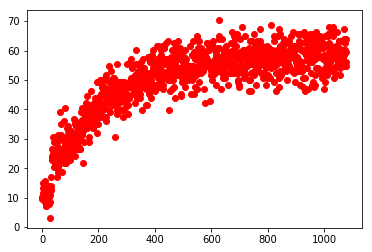

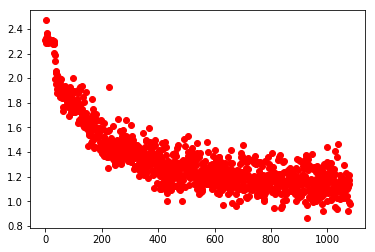

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

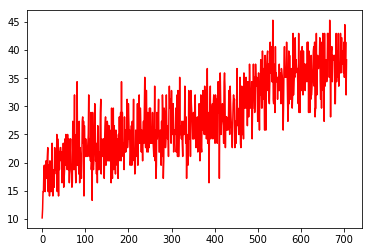

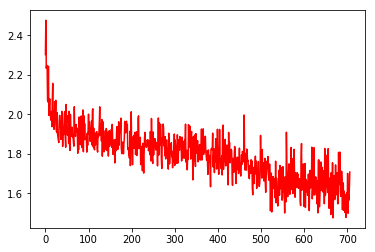

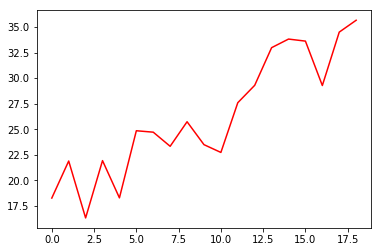

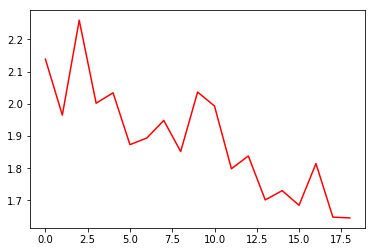

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()